In [1]:
'''
CS6140 Final Project - Paddy Disease Detection – Can technology help relieving Food Crisis 2022?
Aug 1, 2022
Wing Man, Kwok

'''
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from sklearn.model_selection import train_test_split
from PIL import Image                                       #convert Images to tensor
from torch.utils.data import Dataset, DataLoader
import cv2
import torchvision.transforms as T
from PIL import Image
from torchvision import transforms

import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.metrics import classification_report

In [2]:
def get_hyperparameters():
    
    batch_size = 128
    #learning_rate = 1e-3
    learning_rate = 0.01
    n_epochs = 5
    log_interval = 10
    momentum = 0.5
    
    return batch_size, learning_rate, n_epochs, log_interval, momentum

In [3]:
def check_processor():
    
    if torch.cuda.is_available():
        device = 'cuda'
        print('Using cuda\n')
    else:
        device = 'cpu'
        print('Using cpu\n')
        
    return device

In [4]:
class PaddyDataset(Dataset):
    
    def __init__(self, dataframe, label2id, root_dir, is_train, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train
        self.label2id = label2id
        
    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,self.dataframe.iloc[idx, 1],
                                self.dataframe.iloc[idx, 0])
        
        image1 = cv2.imread(img_name)
        image = Image.fromarray(image1)
        
        if self.is_train:
            labelKey = self.dataframe.iloc[idx, 1]
            label = torch.tensor(int(self.label2id[labelKey]))  
        else:
            label =torch.tensor(1)

        if self.transform:
            image = self.transform(image)
        
        return image,label, img_name

In [5]:
def get_label2id(training_csv):
    
    labelArr = training_csv['label'].unique()
    label2id = {}
    id2label = {}
    index = 0
    
    for  class_name in labelArr:
        label2id[class_name] = str(index)
        id2label[str(index)] = class_name
        index=index +1
  
    return label2id, id2label

In [6]:
def EDA(paddy_dataset, images, labels, training_csv):
    
    print("EDA:", "\n")
          
    print("Training Dataset size:", len(paddy_dataset), "\n")
    print("Label Distribution:\n")
    print(paddy_dataset['label'].value_counts(), "\n")
    
    print("Image size (channel, height, width):", images[0].shape, "\n")

In [7]:
def plot(images, labels, id2label, img_name):
    
    plt.subplots(figsize=(15, 15))
    
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.tight_layout()
        plt.axis("off"); plt.xticks([]) ; plt.yticks([]) 
        plt.title("Ground Truth: {}".format(id2label[str(labels[i])]))
        
        images_rgb = images[i].squeeze()
        images_rgb = (np.transpose(images_rgb, (0, 2, 1)).T).detach().numpy()
        plt.imshow(cv2.cvtColor(images_rgb, cv2.COLOR_BGR2RGB))
        
        print(img_name[i])
        
    plt.show()

In [8]:
def train_model(n_epochs, model, train_loader, optimizer, log_interval, device):
    
    model.train()
    
    start_time = time.time()
    
    train_losses = []
    train_counter = []
    criterion = nn.CrossEntropyLoss()
    
    for batch_idx, (data, target, _) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()                           
        output = model(data)
        loss = criterion(output, target)             
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(n_epochs, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((n_epochs-1)*len(train_loader.dataset)))
            '''
            torch.save(model.state_dict(), './model.pth') 
            torch.save(optimizer.state_dict(), './optimizer.pth')
            '''
            
    total_time = time.time() - start_time
    print("Total running time:", total_time)

In [9]:
def val_model(model, val_loader, device):
    
    model.eval()
    
    test_loss = 0
    correct = 0
    model_output = []
    test_losses = []
    files = []
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():                   #no_grad means no gradient magnitude
        for data, target, file_name in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            model_output.append(output)
            files.append(file_name)
            
    test_loss /= len(val_loader.dataset)
    test_losses.append(test_loss)
    accuracy = 100. * correct / len(val_loader.dataset)
    
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(val_loader.dataset), 100. * correct / len(val_loader.dataset)))

    return model_output[0], files, accuracy.item()

In [10]:
def get_resnet_by_batch_size(model, train_dataset, valid_dataset, batch_size, device):
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size = batch_size, num_workers=2)

    model.fc =  nn.Sequential(nn.Dropout(0.1),nn.Linear(512, 10))
    model = model.to(device)
    
    return train_dataloader, val_dataloader, model

Training Dataset size: 9886
Validation Dataset Size: 521 

Mapping of ID and labels {'0': 'bacterial_leaf_blight', '1': 'bacterial_leaf_streak', '2': 'bacterial_panicle_blight', '3': 'blast', '4': 'brown_spot', '5': 'dead_heart', '6': 'downy_mildew', '7': 'hispa', '8': 'normal', '9': 'tungro'} 

Images of first training batch:
../input/paddy-doctor/train_images/normal/100664.jpg


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2314.)
  if sys.path[0] == "":


../input/paddy-doctor/train_images/normal/109781.jpg
../input/paddy-doctor/train_images/dead_heart/101724.jpg
../input/paddy-doctor/train_images/hispa/106414.jpg
../input/paddy-doctor/train_images/bacterial_leaf_streak/108603.jpg


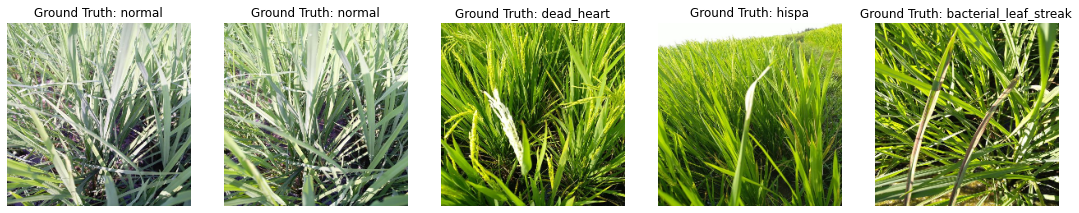

EDA: 

Training Dataset size: 9886 

Label Distribution:

normal                      1683
blast                       1651
hispa                       1498
dead_heart                  1370
tungro                      1036
brown_spot                   913
downy_mildew                 586
bacterial_leaf_blight        463
bacterial_leaf_streak        363
bacterial_panicle_blight     323
Name: label, dtype: int64 

Image size (channel, height, width): torch.Size([3, 224, 224]) 

Using cuda



Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Training Resnet34
Train Epoch: 1 [0/9886 (0%)]	Loss: 2.705312
Train Epoch: 1 [1280/9886 (13%)]	Loss: 1.995084
Train Epoch: 1 [2560/9886 (26%)]	Loss: 1.730441
Train Epoch: 1 [3840/9886 (38%)]	Loss: 1.388280
Train Epoch: 1 [5120/9886 (51%)]	Loss: 0.980242
Train Epoch: 1 [6400/9886 (64%)]	Loss: 0.910641
Train Epoch: 1 [7680/9886 (77%)]	Loss: 0.977657
Train Epoch: 1 [8960/9886 (90%)]	Loss: 0.964775
Total running time: 142.04632759094238

Test set: Avg. loss: 0.0077, Accuracy: 397/521 (76%)

Training Resnet34
Train Epoch: 2 [0/9886 (0%)]	Loss: 0.576250
Train Epoch: 2 [1280/9886 (13%)]	Loss: 0.578885
Train Epoch: 2 [2560/9886 (26%)]	Loss: 0.552436
Train Epoch: 2 [3840/9886 (38%)]	Loss: 0.446240
Train Epoch: 2 [5120/9886 (51%)]	Loss: 0.429748
Train Epoch: 2 [6400/9886 (64%)]	Loss: 0.376492
Train Epoch: 2 [7680/9886 (77%)]	Loss: 0.327555
Train Epoch: 2 [8960/9886 (90%)]	Loss: 0.312311
Total running time: 126.47213459014893

Test set: Avg. loss: 0.0046, Accuracy: 459/521 (88%)

Training Resnet3

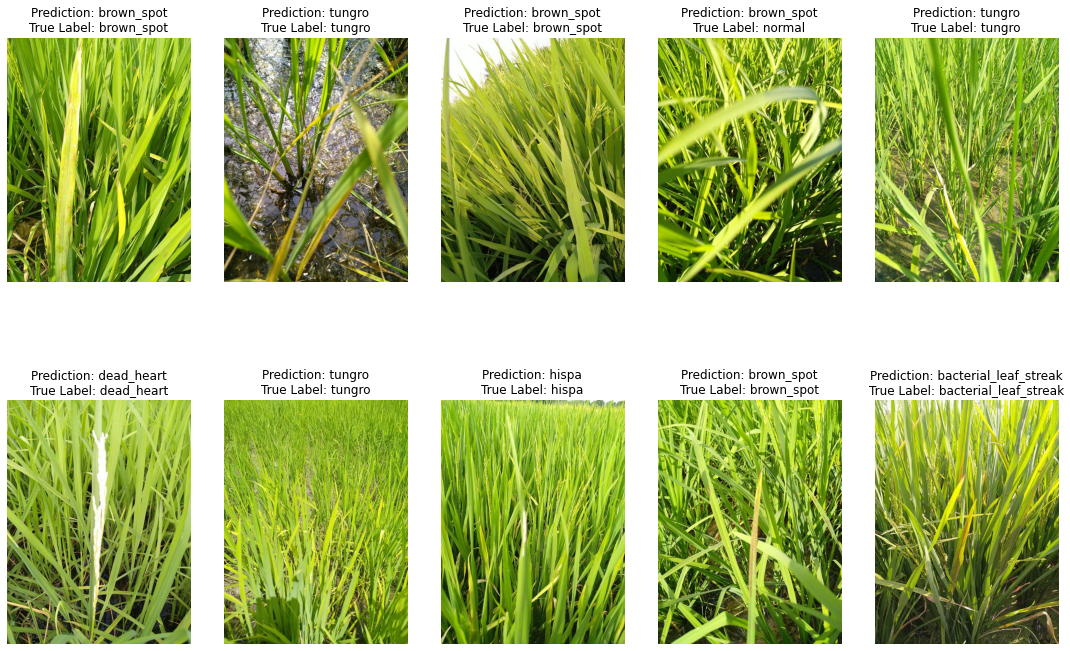

                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.87      0.81      0.84        16
   bacterial_leaf_streak       1.00      0.94      0.97        17
bacterial_panicle_blight       1.00      0.79      0.88        14
                   blast       0.93      0.98      0.96        87
              brown_spot       0.88      0.87      0.87        52
              dead_heart       0.96      0.97      0.97        72
            downy_mildew       0.97      0.91      0.94        34
                   hispa       0.94      0.95      0.94        96
                  normal       0.96      0.95      0.96        81
                  tungro       0.87      0.92      0.90        52

                accuracy                           0.93       521
               macro avg       0.94      0.91      0.92       521
            weighted avg       0.94      0.93      0.93       521



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Training Resnet18
Train Epoch: 1 [0/9886 (0%)]	Loss: 2.475282
Train Epoch: 1 [1280/9886 (13%)]	Loss: 1.963882
Train Epoch: 1 [2560/9886 (26%)]	Loss: 1.715153
Train Epoch: 1 [3840/9886 (38%)]	Loss: 1.678286
Train Epoch: 1 [5120/9886 (51%)]	Loss: 1.381847
Train Epoch: 1 [6400/9886 (64%)]	Loss: 1.210174
Train Epoch: 1 [7680/9886 (77%)]	Loss: 1.180238
Train Epoch: 1 [8960/9886 (90%)]	Loss: 1.022423
Total running time: 100.90233373641968

Test set: Avg. loss: 0.0092, Accuracy: 355/521 (68%)

Training Resnet18
Train Epoch: 2 [0/9886 (0%)]	Loss: 0.818846
Train Epoch: 2 [1280/9886 (13%)]	Loss: 0.792598
Train Epoch: 2 [2560/9886 (26%)]	Loss: 0.681949
Train Epoch: 2 [3840/9886 (38%)]	Loss: 0.795252
Train Epoch: 2 [5120/9886 (51%)]	Loss: 0.677639
Train Epoch: 2 [6400/9886 (64%)]	Loss: 0.601878
Train Epoch: 2 [7680/9886 (77%)]	Loss: 0.501877
Train Epoch: 2 [8960/9886 (90%)]	Loss: 0.615038
Total running time: 101.93967294692993

Test set: Avg. loss: 0.0061, Accuracy: 423/521 (81%)

Training Resnet1

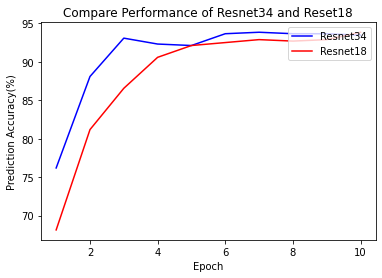

Training Resnet34, batch size 256
Train Epoch: 1 [0/9886 (0%)]	Loss: 2.399814
Train Epoch: 1 [2560/9886 (26%)]	Loss: 1.899329
Train Epoch: 1 [5120/9886 (51%)]	Loss: 1.602697
Train Epoch: 1 [7680/9886 (77%)]	Loss: 1.305382
Total running time: 125.09580993652344

Test set: Avg. loss: 0.0080, Accuracy: 325/521 (62%)

Training Resnet34, batch size 256
Train Epoch: 2 [0/9886 (0%)]	Loss: 1.140458
Train Epoch: 2 [2560/9886 (26%)]	Loss: 0.989543
Train Epoch: 2 [5120/9886 (51%)]	Loss: 0.795886
Train Epoch: 2 [7680/9886 (77%)]	Loss: 0.729443
Total running time: 125.74148607254028

Test set: Avg. loss: 0.0054, Accuracy: 409/521 (79%)

Training Resnet34, batch size 256
Train Epoch: 3 [0/9886 (0%)]	Loss: 0.565646
Train Epoch: 3 [2560/9886 (26%)]	Loss: 0.445806
Train Epoch: 3 [5120/9886 (51%)]	Loss: 0.399059
Train Epoch: 3 [7680/9886 (77%)]	Loss: 0.401581
Total running time: 127.02953171730042

Test set: Avg. loss: 0.0041, Accuracy: 441/521 (85%)

Training Resnet34, batch size 256
Train Epoch: 4 [0/

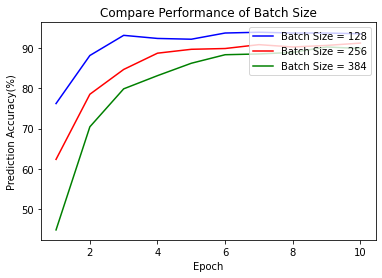

Training Resnet34, learning rate 0.001
Train Epoch: 1 [0/9886 (0%)]	Loss: 2.453611
Train Epoch: 1 [1280/9886 (13%)]	Loss: 2.201935
Train Epoch: 1 [2560/9886 (26%)]	Loss: 2.112359
Train Epoch: 1 [3840/9886 (38%)]	Loss: 2.079148
Train Epoch: 1 [5120/9886 (51%)]	Loss: 2.150839
Train Epoch: 1 [6400/9886 (64%)]	Loss: 2.046706
Train Epoch: 1 [7680/9886 (77%)]	Loss: 1.945068
Train Epoch: 1 [8960/9886 (90%)]	Loss: 1.870591
Total running time: 123.75250673294067

Test set: Avg. loss: 0.0181, Accuracy: 197/521 (38%)

Training Resnet34, learning rate 0.001
Train Epoch: 2 [0/9886 (0%)]	Loss: 1.814064
Train Epoch: 2 [1280/9886 (13%)]	Loss: 1.827852
Train Epoch: 2 [2560/9886 (26%)]	Loss: 1.814067
Train Epoch: 2 [3840/9886 (38%)]	Loss: 1.759041
Train Epoch: 2 [5120/9886 (51%)]	Loss: 1.771059
Train Epoch: 2 [6400/9886 (64%)]	Loss: 1.677215
Train Epoch: 2 [7680/9886 (77%)]	Loss: 1.665955
Train Epoch: 2 [8960/9886 (90%)]	Loss: 1.643667
Total running time: 123.96722602844238

Test set: Avg. loss: 0.0157,

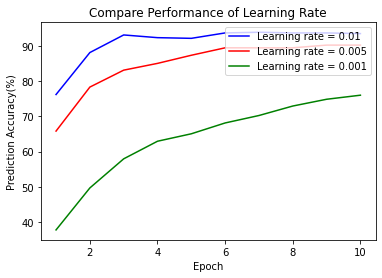

Total running time: 7678.545666694641


In [11]:
def main(argv):

    torch.cuda.empty_cache()
    
    # -------- Prepare dataset and dataloader
    start_time = time.time()
    
    torch.manual_seed(42)  
    torch.backends.cudnn.enabled = False
    
    batch_size, learning_rate, n_epochs, log_interval, momentum  = get_hyperparameters()

    training_csv = pd.read_csv("../input/paddy-doctor/train.csv")
    train, valid = train_test_split(training_csv, test_size=0.05,random_state=0)
    print("Training Dataset size:", len(train)); print("Validation Dataset Size:", len(valid), "\n")
    
    label2id, id2label = get_label2id(training_csv)
    print("Mapping of ID and labels", id2label, "\n")

    transform_dataset = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])
    
    train_dataset = PaddyDataset(train, label2id, root_dir='../input/paddy-doctor/train_images', is_train=True, transform=transform_dataset)
    valid_dataset = PaddyDataset(valid, label2id, root_dir='../input/paddy-doctor/train_images', is_train=True, transform=transform_dataset)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size = batch_size, num_workers=2)
    
    images, labels, img_name = next(iter(train_dataloader))
    print("Images of first training batch:")
    plot(images, labels.tolist(), id2label, img_name)
    
    EDA(train, images, labels, training_csv)

    device = check_processor()
    
    # --------- Define resnet34 model
    
    resnet34 = models.resnet34(pretrained=True)
    
    train_dataloader, val_dataloader, resnet34 = get_resnet_by_batch_size(resnet34, train_dataset, valid_dataset, batch_size, device)
    
    optimizer_resnet34 = optim.SGD(resnet34.parameters(), lr=learning_rate, momentum=momentum)
    
    # ---------- load previous training weights
    
    '''
    network_state_dict = torch.load('../input/paddy-disease-detection/model.pth', map_location = device)
    resnet34.load_state_dict(network_state_dict)
    
    optimizer_state_dict = torch.load('../input/paddy-disease-detection/optimizer.pth', map_location = device)
    optimizer.load_state_dict(optimizer_state_dict)
    '''
    
    # ------- Train Resnet34 as baseline for comparison
    
    n_epochs = 10
    
    accuracy_resnet34 = []
    
    for epoch in range(1, n_epochs + 1): 
        print("Training Resnet34")
        train_model(epoch, resnet34, train_dataloader, optimizer_resnet34, log_interval, device)
        pred, filenames, accuracy = val_model(resnet34, val_dataloader, device)
        accuracy_resnet34.append(accuracy)
               
    print("accuracy_resnet34", accuracy_resnet34)
        
    # ------- Visualize reset34 baseline prediction
    val_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size = len(valid), num_workers=2)
    
    test_samples = enumerate(val_dataloader)
    batch_idx, (test_images, test_targets, _) = next(test_samples)
    print("test_targets")
    print(test_targets.tolist())
    print("test_images shape", test_images.shape)
    
    pred, filenames, accuracy = val_model(resnet34, val_dataloader, device)
    
    transform = T.ToPILImage()
    
    plt.subplots(figsize=(15, 15))
    
    for i in range(10):
        plt.subplot(3, 5, i+1)
        plt.tight_layout()
        plt.axis("off"); plt.xticks([]) ; plt.yticks([]) 
        
        prediction = np.argmax(pred[i].cpu()).item()
        true_label = test_targets.tolist()[i]
        
        plt.title("Prediction: " + id2label[str(prediction)] + "\n" + "True Label: " + id2label[str(true_label)])
        plt.imshow(cv2.cvtColor(cv2.imread(filenames[0][i]), cv2.COLOR_BGR2RGB))
      
        print(filenames[0][i])
        
    plt.show()
    
    # ------- Visualize reset34 accuracy report
    
    prediction_list = []
    
    for i in range(pred.shape[0]):
        prediction = np.argmax(pred[i].cpu()).item()
        prediction_list.append(id2label[str(prediction)])
    
    true_label = valid['label'].values.tolist()
    target_names = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']
    
    print(classification_report(true_label,  prediction_list, target_names = target_names))
    
    # --------- Define resnet18 model
    
    resnet18 = models.resnet18(pretrained=True)
    
    train_dataloader, val_dataloader, resnet18 = get_resnet_by_batch_size(resnet18, train_dataset, valid_dataset, batch_size, device)
    
    optimizer_resnet18 = optim.SGD(resnet18.parameters(), lr=learning_rate, momentum=momentum)
    
    # ----- Train Resnet18 and compare Resnet34 and Reset18
    
    accuracy_resnet18 = []
    
    for epoch in range(1, n_epochs + 1): 
        print("Training Resnet18")
        train_model(epoch, resnet18, train_dataloader, optimizer_resnet18, log_interval, device)
        pred, filenames, accuracy = val_model(resnet18, val_dataloader, device)
        accuracy_resnet18.append(accuracy)
 
    print("accuracy_resnet18", accuracy_resnet18, "\n")

    epoch = np.linspace(1,len(accuracy_resnet34),len(accuracy_resnet34));
    
    plt.title("Compare Performance of Resnet34 and Reset18"); plt.xlabel("Epoch"); plt.ylabel("Prediction Accuracy(%)")
    plt.plot(epoch, accuracy_resnet34, color = 'blue' )
    plt.plot(epoch, accuracy_resnet18, color = 'red' )
    plt.legend(['Resnet34', 'Resnet18'], loc='upper right')
    plt.show()
    
    # ------ Compare Batch Size
    # -------------------------- Get model by batch size 256
      
    batch_size = 256
    accuracy_resnet34_batch_256 = []
    
    resnet34_batch_256 = models.resnet34(pretrained=True)
    
    train_dataloader, val_dataloader, resnet34_batch_256 = get_resnet_by_batch_size(resnet34_batch_256, train_dataset, valid_dataset, batch_size, device)

    optimizer_resnet34_batch_256 = optim.SGD(resnet34_batch_256.parameters(), lr=learning_rate, momentum=momentum)
    
    for epoch in range(1, n_epochs + 1): 
        print("Training Resnet34, batch size", batch_size)
        train_model(epoch, resnet34_batch_256, train_dataloader, optimizer_resnet34_batch_256, log_interval, device)
        pred, filenames, accuracy = val_model(resnet34_batch_256, val_dataloader, device)
        accuracy_resnet34_batch_256.append(accuracy)
               
    print("accuracy_resnet34_batch_256", accuracy_resnet34_batch_256, "\n")
    
     # -------------------------- Get model by batch size 384
        
    batch_size = 384   
    accuracy_resnet34_batch_384 = []
    
    resnet34_batch_384 = models.resnet34(pretrained=True)
    
    train_dataloader, val_dataloader, resnet34_batch_384 = get_resnet_by_batch_size(resnet34_batch_384, train_dataset, valid_dataset, batch_size, device)

    optimizer_resnet34_batch_384 = optim.SGD(resnet34_batch_384.parameters(), lr=learning_rate, momentum=momentum)
    
    for epoch in range(1, n_epochs + 1): 
        print("Training Resnet34, batch size", batch_size)
        train_model(epoch, resnet34_batch_384, train_dataloader, optimizer_resnet34_batch_384, log_interval, device)
        pred, filenames, accuracy = val_model(resnet34_batch_384, val_dataloader, device)
        accuracy_resnet34_batch_384.append(accuracy)
               
    print("accuracy_resnet34_batch_384", accuracy_resnet34_batch_384, "\n")
    
    epoch = np.linspace(1,len(accuracy_resnet34_batch_256),len(accuracy_resnet34_batch_256));
    
    plt.title("Compare Performance of Batch Size"); plt.xlabel("Epoch"); plt.ylabel("Prediction Accuracy(%)")
    plt.plot(epoch, accuracy_resnet34, color = 'blue' )
    plt.plot(epoch, accuracy_resnet34_batch_256, color = 'red' )
    plt.plot(epoch, accuracy_resnet34_batch_384, color = 'green' )
    plt.legend(['Batch Size = 128', 'Batch Size = 256', 'Batch Size = 384'], loc='upper right')
    plt.show()

    # ------ Compare learning rate
    #------------------------ learning rate = 0.01
    
    batch_size = 128
    accuracy_resnet34_lr_01 = []
    
    resnet34_lr_01 = models.resnet34(pretrained=True)
    
    train_dataloader, val_dataloader, resnet34_lr_01 = get_resnet_by_batch_size(resnet34_lr_01, train_dataset, valid_dataset, batch_size, device)

    #optimizer_resnet34_lr_01 = optim.SGD(resnet34_lr_01.parameters(), lr=0.01, momentum = momentum)    # <------------------
    optimizer_resnet34_lr_01 = optim.SGD(resnet34_lr_01.parameters(), lr=0.001, momentum = momentum) 
    
    for epoch in range(1, n_epochs + 1): 
        print("Training Resnet34, learning rate 0.001")                                                  # <------------------
        train_model(epoch, resnet34_lr_01, train_dataloader, optimizer_resnet34_lr_01, log_interval, device)
        pred, filenames, accuracy = val_model(resnet34_lr_01, val_dataloader, device)
        accuracy_resnet34_lr_01.append(accuracy)
               
    print("accuracy_resnet34_lr_01", accuracy_resnet34_lr_01, "\n")
    
    #------------------------- learning rate = 0.05
    accuracy_resnet34_lr_005 = []
    
    resnet34_lr_005 = models.resnet34(pretrained=True)
    
    train_dataloader, val_dataloader, resnet34_lr_005 = get_resnet_by_batch_size(resnet34_lr_005, train_dataset, valid_dataset, batch_size, device)

    optimizer_resnet34_lr_005 = optim.SGD(resnet34_lr_005.parameters(), lr=0.005, momentum = momentum)
    
    for epoch in range(1, n_epochs + 1): 
        print("Training Resnet34, learning rate 0.05")
        train_model(epoch, resnet34_lr_005, train_dataloader, optimizer_resnet34_lr_005, log_interval, device)
        pred, filenames, accuracy = val_model(resnet34_lr_005, val_dataloader, device)
        accuracy_resnet34_lr_005.append(accuracy)
               
    print("accuracy_resnet34_lr_005", accuracy_resnet34_lr_005, "\n")
    
    epoch = np.linspace(1,len(accuracy_resnet34_lr_01),len(accuracy_resnet34_lr_01))
    
    plt.title("Compare Performance of Learning Rate"); plt.xlabel("Epoch"); plt.ylabel("Prediction Accuracy(%)")
    plt.plot(epoch, accuracy_resnet34, color = 'blue' )
    plt.plot(epoch, accuracy_resnet34_lr_005, color = 'red' )
    plt.plot(epoch, accuracy_resnet34_lr_01, color = 'green' )
    plt.legend(['Learning rate = 0.01', 'Learning rate = 0.005', 'Learning rate = 0.001'], loc='upper right')     # <------------------
    plt.show()
    
    # ----- Compute total time
    total_time = time.time() - start_time
    print("Total running time:", total_time)
                  
    return

if __name__ == "__main__":
    main(sys.argv)


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session